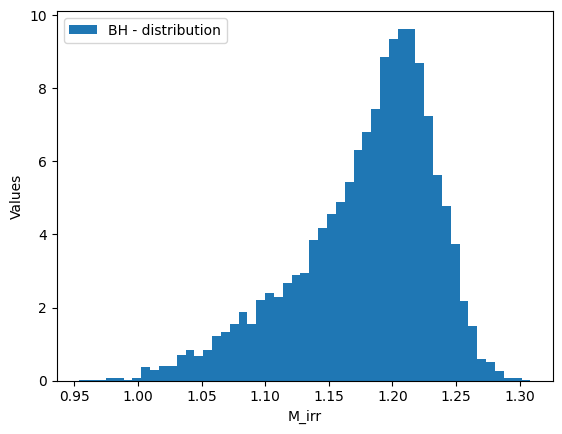

In [35]:
import numpy as np
from matplotlib import pyplot as plt
from astroML import stats as astroMLstats

N = 10000

sigma = 0.02
mu = 1
M = np.random.normal(mu, sigma, N)
chi = np.random.uniform(0,1,N)

M_irr = M * np.sqrt( 1+ np.sqrt(1-chi**2)/2) #per definizione

sigmaG2 = astroMLstats.sigmaG(M_irr) # quantile al 75 - quantile al 25
binsize = 2.7 * sigmaG2 / (N**(1/3)) #formula di Freedman-Diaconis
binsG = np.append( np.arange(start=M_irr.min(), stop=M_irr.max(), step=binsize) , M_irr.max()) 

plt.hist(M_irr, 51, density=True, label = "BH - distribution")
plt.xlabel("M_irr")
plt.ylabel("Values")
plt.legend()
plt.show()

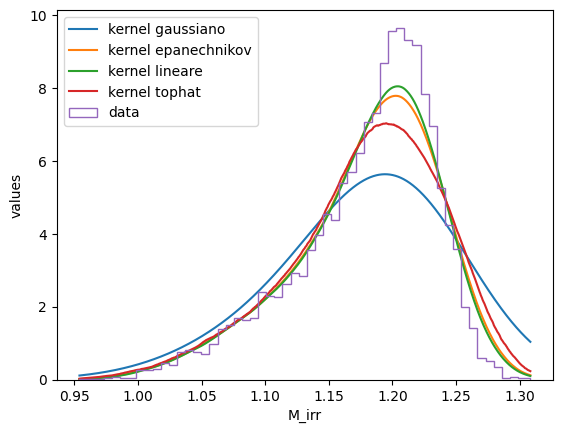

In [36]:
from sklearn.neighbors import KernelDensity

xgrid = np.linspace(M_irr.min(),M_irr.max(),1000)  

def kde (data, bandwidth, kernel):
    KDE = KernelDensity(bandwidth = bandwidth, kernel = kernel)
    KDE.fit(data[:, np.newaxis]) 
    log_pdf = KDE.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)


bandwidth = 0.05

pdf = kde (M_irr, bandwidth, kernel = "gaussian")       # funzione di densità della distribuzione normale
pdf2 = kde (M_irr, bandwidth, kernel = "epanechnikov")  # parabolico e ha un supporto finito, stima più localizzata rispetto al gaussiano
pdf3 = kde (M_irr, bandwidth, kernel = "linear")        # assegna pesi decrescenti linearmente alla distanza dal punto di riferimento. densità meno liscia rispetto al gaussiano
pdf4 = kde (M_irr, bandwidth, kernel = "tophat")        # kernel uniforme, che assegna lo stesso peso a tutti i punti entro una certa finestra e zero al di fuori. meno utilizzato perché può generare stime meno precise

plt.plot(xgrid,pdf, label = "kernel gaussiano")
plt.plot(xgrid,pdf2, label = "kernel epanechnikov")
plt.plot(xgrid,pdf3, label = "kernel lineare")
plt.plot(xgrid,pdf4, label = "kernel tophat")

plt.hist(M_irr, binsG, label = "data", density= True, histtype="step")
plt.xlabel("M_irr")
plt.ylabel("values")
plt.legend()
plt.show()


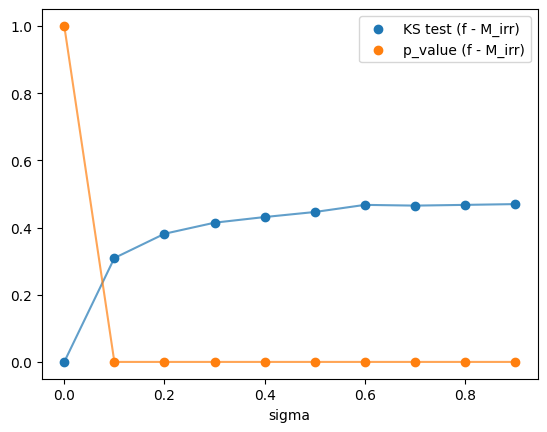

In [37]:
import scipy as sp

statistic = []
p_value = []
x = []

for i in range(10) :

    sigma =  i/10

    chi_1 = np.random.uniform(0,1,N)
    M = np.random.normal(mu, sigma, N)

    M_irr = M * np.sqrt(( 1+ np.sqrt(1-chi**2))/2)
    f = np.sqrt(( 1+ np.sqrt(1-chi**2))/2)

    statistic_i , p_value_i = sp.stats.ks_2samp(f , M_irr)

    #kstest: Esegue il test KS su un campione rispetto a una distribuzione.
    #ks_2samp: Confronta due campioni indipendenti.

    statistic.append(statistic_i)
    p_value.append(p_value_i)

    x.append(sigma)


plt.scatter(x,statistic, label = "KS test (f - M_irr)")
plt.plot(x, statistic, linestyle="-", alpha=0.7)

plt.scatter(x, p_value, label = "p_value (f - M_irr)")
plt.plot(x, p_value, linestyle="-", alpha=0.7)

plt.xlabel("sigma")

plt.legend()
plt.show()


Il test KS nasce per vedere quanto vale il massimo della differenza tra due funzioni.
Come si vede dal grafico sopra, nel limite di $\sigma = 0$ (cioè una Dirac-delta), $M$ è una costante pari a $\mu$, il KS test restituisce il valore di 0, con un p-value di 1. Questo ad indicare che le due funzioni sono propriamente le stesse. <br>
Al crescere di $\sigma$ invece giungiamo rapidamente ad una saturazione, con il valore del p-value che crolla circa a 0. Questa crescita della statistica KS segnala una differenza crescente tra le due distribuzioni. <br>
Quando $\sigma$ diventa maggiore di 0.3, la statistica KS si stabilizza attorno a 0.4 / 0.45, suggerendo che la differenza tra le distribuzioni non aumenta più in modo significativo. <br>
Il motivo di questo comportamento è da cercarsi nella definizione di $f$, che non dipende in alcun modo da $\sigma$, mentre $M_{\text{irr}}$ ne subisce l'influenza essendo $M$ distribuita gaussianamente, proprio con larghezza $\sigma$. <br>
Dopo 0.3 la dispersione di $M$ è abbastanza grande da rendere le due distribuzioni diverse in modo significativo. Tuttavia, la differenza tra le distribuzioni raggiunge un limite perché il rapporto $f$ rimane sempre limitato nella stessa gamma di valori compresi tra 1 e 0.7 (si può vedere dal plot sotto).

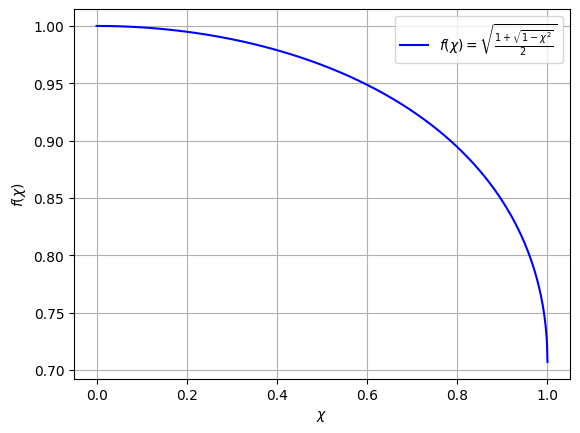

In [38]:
def fun(chi):
    return np.sqrt((1 + np.sqrt(1 - chi**2)) / 2)

chi_values = np.linspace(0, 1, 1000)
f_values = fun(chi_values)

plt.plot(chi_values, f_values, label=r'$f(\chi) = \sqrt{\frac{1 + \sqrt{1 - \chi^2}}{2}}$', color="blue")
plt.xlabel(r'$\chi$')
plt.ylabel(r'$f(\chi)$')
plt.grid(True)
plt.legend()
plt.show()

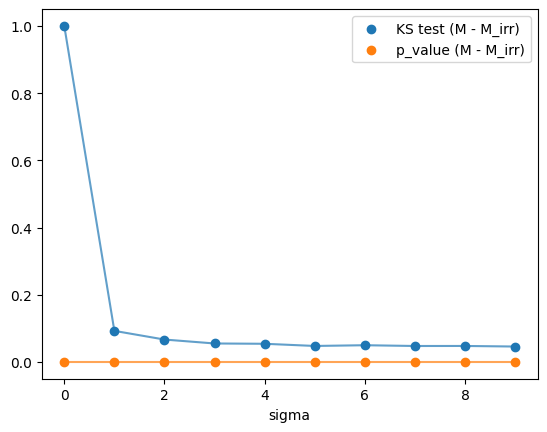

In [39]:
statistic = []
p_value_2 = []
x = []

for i in range(10) :

    sigma =  i
    chi = np.random.uniform(0,1,N)
    M = np.random.normal(mu, sigma, N)
    M_irr = M * np.sqrt( 1+ np.sqrt(1-chi**2)/2)

    statistic_i , p_value_i = sp.stats.ks_2samp(M , M_irr)

    statistic.append(statistic_i)
    p_value_2.append(p_value_i)

    x.append(sigma)


plt.scatter(x,statistic, label = "KS test (M - M_irr)")
plt.plot(x, statistic, linestyle="-", alpha=0.7)

plt.scatter(x, p_value_2, label = "p_value (M - M_irr)")
plt.plot(x, p_value_2, linestyle="-", alpha=0.7)

plt.xlabel("sigma")

plt.legend()
plt.show()

Nel primo test abbiamo confrontato la distribuzione del rapporto con quella di M_irr. <br>
Nel secondo test è stato confrontato direttamente con M. <br>
Questa trasformazione introduce una moltiplicazione punto per punto su M che dipende da $\chi$, e quindi modifica la forma della distribuzione.

Per piccoli valori di $\sigma$, M è molto concentrato attorno a $\mu$ e la trasformazione introduce una distorsione significativa, rendendo la distribuzione molto diversa da quella di M. la statistica KS risulta elevata e il p_value basso.

Per grandi valori di $\sigma$ invece, M è molto disperso, la moltiplicazione punto per punto con il fattore "f"  ha un effetto relativo minore, e
le due distribuzioni tendono a somigliarsi, con una statistica KS che decresce.

Per quanto riguarda il p_value, nel test KS indica quanto è probabile ottenere una distanza tra le distribuzioni almeno grande quanto quella osservata, se le due distribuzioni fossero in realtà uguali. Quando N è grande (nel nostro caso 10000), anche una piccola distanza tra le distribuzioni produce una statistica KS che può essere piccola in valore assoluto, ma per il test del p_value si giunge egualmente a zero numerico.
Si può stampare il valore e osservarne la crescita.


/tmp/ipykernel_12781/3622065941.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(x,np.log(p_value_2), label = "p_value (M - M_irr)")
/tmp/ipykernel_12781/3622065941.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(p_value_2), linestyle="-", alpha=0.7)


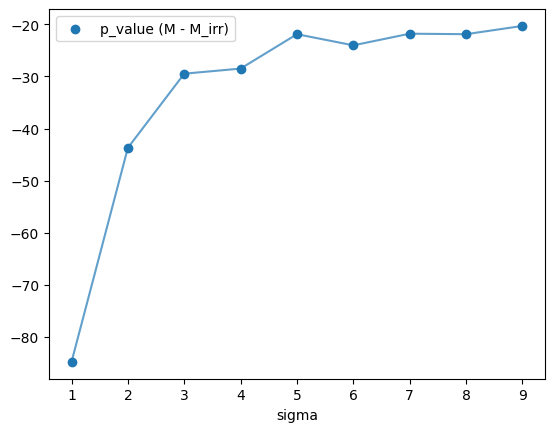

In [40]:
plt.scatter(x,np.log(p_value_2), label = "p_value (M - M_irr)")
plt.plot(x, np.log(p_value_2), linestyle="-", alpha=0.7)

#plt.scatter(x,np.log(p_value)/100, label = "p_value (f - M_irr)")
#plt.plot(x, np.log(p_value)/100, linestyle="-", alpha=0.7)
# non è plottabile perchè va identicamente a 0, già il primo punto è 10^-323 ...

plt.xlabel("sigma")

plt.legend()
plt.show()

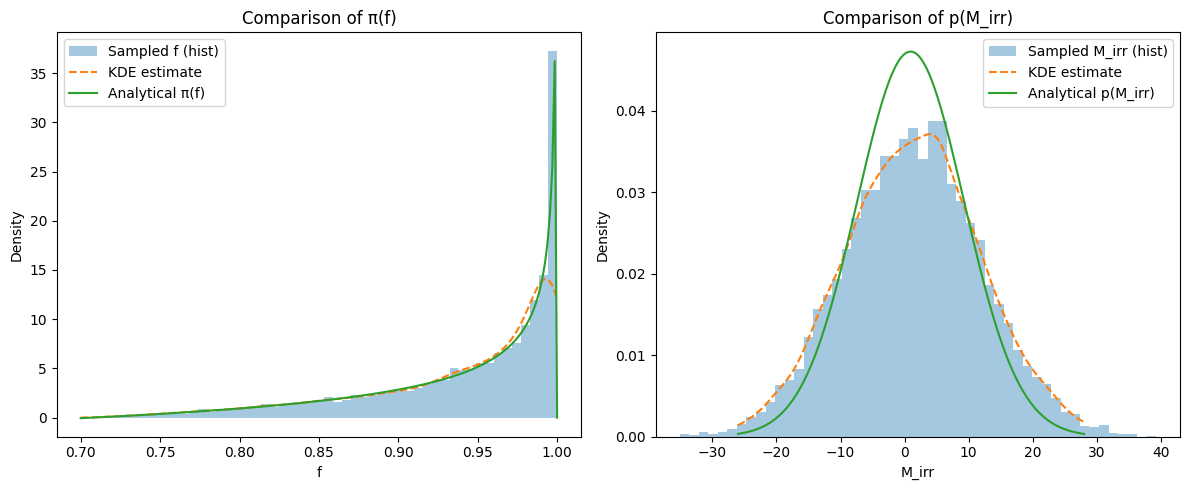

In [42]:
# Questo metodo calcola le PDF dei dati usando il KDE con una sigma impostata di default e ricavavta dalla regola di scott
kde_f = sp.stats.gaussian_kde(f)
kde_Mirr = sp.stats.gaussian_kde(M_irr)

# Definizione della pdf analitica di f, l'ho calcolata sotto ma è meglio lasciar perdere
def pi_f(f):
    return 2 * (2*f**2 - 1) / np.sqrt(1 - f**2) if 0 < f < 1 else 0

# Discretizziamo l'asse per il plot
f_vals = np.linspace(0.7, 1, 200)
pi_f_vals = np.array([pi_f(fi) for fi in f_vals])

# sigma = 0.02
# mu = 1

# Definizione della pdf analitica di M_irr
def p_Mirr(M_irr, sigma, mu):
    integrand = lambda f: np.exp(-((M_irr / f - mu)**2) / (2 * sigma**2)) * (2*f**2 - 1) / (f * np.sqrt(1 - f**2)) #boh, è un modo di python per definire una funzione anonima
    norm_factor = np.sqrt(2 / np.pi) / sigma
    integral, _ = sp.integrate.quad(integrand, 1/np.sqrt(2), 1) #La funzione quad di SciPy viene usata per integrare integrand rispetto a f.
    return norm_factor * integral

# Calcoliamo la pdf di M_irr su un range di valori
M_irr_vals = np.linspace(mu - 3*sigma, mu + 3*sigma, 200)
p_Mirr_vals = np.array([p_Mirr(Mi, sigma, mu) for Mi in M_irr_vals])

# Plot della distribuzione di f
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(f, bins=50, density=True, alpha=0.4, label="Sampled f (hist)")
plt.plot(f_vals, kde_f(f_vals), label="KDE estimate", linestyle="dashed")
plt.plot(f_vals, pi_f_vals, label="Analytical π(f)", linestyle="solid")
plt.xlabel("f")
plt.ylabel("Density")
plt.legend()
plt.title("Comparison of π(f)")

# Plot della distribuzione di M_irr
plt.subplot(1, 2, 2)
plt.hist(M_irr, bins=50, density=True, alpha=0.4, label="Sampled M_irr (hist)")
plt.plot(M_irr_vals, kde_Mirr(M_irr_vals), label="KDE estimate", linestyle="dashed")
plt.plot(M_irr_vals, p_Mirr_vals, label="Analytical p(M_irr)", linestyle="solid")
plt.xlabel("M_irr")
plt.ylabel("Density")
plt.legend()
plt.title("Comparison of p(M_irr)")

plt.tight_layout()
plt.show()


# Calcolo della CDF
Dobbiamo calcolare la funzione di distribuzione cumulativa (CDF) della funzione:

$$
f(x) = \sqrt{\frac{1 + \sqrt{1 - x^2}}{2}}, \quad 0 \leq x \leq 1
$$

La CDF è definita come:


$$
F(x') = \int_0^{x'} f(x) \, dx = \int_0^{x'} \sqrt{\frac{1 + \sqrt{1 - x^2}}{2}} \, dx
$$


---

**1. Cambio di variabile**  
Poniamo:

$$
u = f(x) = \sqrt{\frac{1 + \sqrt{1 - x^2}}{2}}
$$

Deriviamo rispetto a \( x \):

$$
du = \frac{1}{2} \cdot \frac{1}{\sqrt{2(1+\sqrt{1-x^2})}} \cdot \frac{-x}{\sqrt{1-x^2}} \, dx
$$

Semplificando:

$$
du = \frac{-x}{2\sqrt{2(1+\sqrt{1-x^2})} \cdot \sqrt{1-x^2}} \, dx
$$

Risolvendo per \( dx \):

$$
dx = \frac{-2\sqrt{2(1+\sqrt{1-x^2})} \cdot \sqrt{1-x^2}}{x} \, du
$$

---

**2. Sostituzione nell'integrale**  
Dopo aver sostituito i termini e semplificato l'integrale, otteniamo il risultato finale:

$$
F(x) = 2 \cdot \frac{2f^2 - 1}{\sqrt{1 - f^2}}
$$

Dove \( f(x) \) è:

$$
f(x) = \sqrt{\frac{1 + \sqrt{1 - x^2}}{2}}
$$

---

**Conclusione**  
Abbiamo calcolato analiticamente la CDF della funzione data. Il risultato finale è:

$$
F(x) = 2 \cdot \frac{2f^2 - 1}{\sqrt{1 - f^2}}
$$



